<a href="https://colab.research.google.com/github/niplessa/A-study-on-medical-and-sociological-Data-regarding-Covid19-Thesis-/blob/main/Covid19_timeSeries_and_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Plots using Folium and Chloropleth. World and Europe.

### Datasets: Timeseries datasets from John Hopkins University. Accesed from: https://github.com/CSSEGISandData/COVID-19 , uploaded last edition (13/10) to my github


Install and import libraries

In [ ]:
!pip install pycountry_convert

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests


In [ ]:
#import datasets
conf = "https://raw.githubusercontent.com/niplessa/Datasets/main/time_series_covid_19_confirmed.csv"
death = "https://raw.githubusercontent.com/niplessa/Datasets/main/time_series_covid_19_deaths.csv"

cov19 = "https://raw.githubusercontent.com/niplessa/Datasets/main/cases_country.csv"
tabl =  "https://raw.githubusercontent.com/niplessa/Datasets/main/cases_time.csv"

In [ ]:
df_confirmed = pd.read_csv(conf) #time series confirmed cases globally
df_deaths = pd.read_csv(death) #time series deaths globally
df_covid19 = pd.read_csv(cov19) #aggregated data for each country [13/10]
df_table = pd.read_csv(tabl,parse_dates=['Last_Update']) #cumulative data for each country[13/10]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
#fill na and infs
from numpy import inf
df_covid19['Recovered'][(df_covid19['Recovered']== -inf) | (df_covid19['Recovered']== inf)] = 0
df_covid19['Recovered']=df_covid19['Recovered'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#convert floats to int
df_covid19.Confirmed = df_covid19.Confirmed.astype("int64")
df_covid19.Deaths =df_covid19.Deaths.astype("int64")
df_covid19.Recovered =df_covid19.Recovered.astype("int64")

In [ ]:
#preproccess - rename columns
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

## Inspect DataFrames


In [ ]:
df_confirmed.head()

state      country       Lat       Long  ...  9/20/20  9/21/20  9/22/20  9/23/20
0   NaN  Afghanistan  33.93911  67.709953  ...    39044    39074    39096    39145
1   NaN      Albania  41.15330  20.168300  ...    12385    12535    12666    12787
2   NaN      Algeria  28.03390   1.659600  ...    49826    50023    50214    50400
3   NaN      Andorra  42.50630   1.521800  ...     1564     1681     1681     1753
4   NaN       Angola -11.20270  17.873900  ...     3991     4117     4236     4363

[5 rows x 250 columns]

In [ ]:
df_covid19.head()

country          Last_Update       Lat  ...  Mortality_Rate  UID  ISO3
0  Afghanistan  2020-10-14 10:24:04  33.93911  ...        3.700555    4   AFG
1      Albania  2020-10-14 10:24:04  41.15330  ...        2.723464    8   ALB
2      Algeria  2020-10-14 10:24:04  28.03390  ...        3.404558   12   DZA
3      Andorra  2020-10-14 10:24:04  42.50630  ...        1.903172   20   AND
4       Angola  2020-10-14 10:24:04 -11.20270  ...        3.323353   24   AGO

[5 rows x 14 columns]

In [ ]:
df_table.head()

Country_Region Last_Update  Confirmed  ...  iso3  Report_Date_String  Delta_Deaths
0    Afghanistan  2020-01-22          0  ...   AFG          2020/01/22           0.0
1    Afghanistan  2020-01-23          0  ...   AFG          2020/01/23           0.0
2    Afghanistan  2020-01-24          0  ...   AFG          2020/01/24           0.0
3    Afghanistan  2020-01-25          0  ...   AFG          2020/01/25           0.0
4    Afghanistan  2020-01-26          0  ...   AFG          2020/01/26           0.0

[5 rows x 17 columns]

In [ ]:
# Changing the country names as required by pycountry_convert Lib

df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])

In [ ]:
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

In [ ]:
# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

In [ ]:
#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])

In [ ]:
df_table = df_table[df_table["continent"] != "Others"]

In [ ]:
#see what is classified as "others"
df_deaths[df_deaths["continent" ]== 'Others']

state             country continent  ...  9/21/20  9/22/20  9/23/20
34    NaN               Burma    Others  ...      100      116      133
102   NaN    Diamond Princess    Others  ...       13       13       13
139   NaN            Holy See    Others  ...        0        0        0
156   NaN              Kosovo    Others  ...      488      488      488
168   NaN          MS Zaandam    Others  ...        2        2        2
237   NaN         Timor-Leste    Others  ...        0        0        0
261   NaN  West Bank and Gaza    Others  ...      265      269      272
262   NaN      Western Sahara    Others  ...        1        1        1

[8 rows x 251 columns]

In [ ]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

## Define some functions that will be used:


In [ ]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""+"output/"


In [ ]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update',"Incident_Rate","People_Tested","People_Hospitalized","Mortality_Rate","UID"],axis =1)
df_countries_cases.index = df_countries_cases["country"]
#df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update','Incident_Rate',"People_Tested","People_Hospitalized","Mortality_Rate","UID"],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

## World Maps


In [ ]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)


### Interactive World map


In [ ]:
world_map

## World Heat Map (confirmed)


In [ ]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
#fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Blues")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()


## World Heat Map (Deaths)

In [ ]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
#fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Deaths Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Deaths (Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map deaths.png")
fig.show()

## Animation of Covid19 Spread

In [ ]:
df_data = df_table.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index()
df_data["Last_Update"] = pd.to_datetime( df_data["Last_Update"]).dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(df_data, locations="Country_Region", locationmode='country names', 
                     color=np.power(df_data["Confirmed"],0.3)-2 , size= np.power(df_data["Confirmed"]+1,0.3)-1, hover_name="Country_Region",
                     hover_data=["Confirmed"],
                     range_color= [0, max(np.power(df_data["Confirmed"],0.3))], 
                     projection="natural earth", animation_frame="Last_Update", 
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='COVID-19: Progression of spread'
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



## How many countries affected

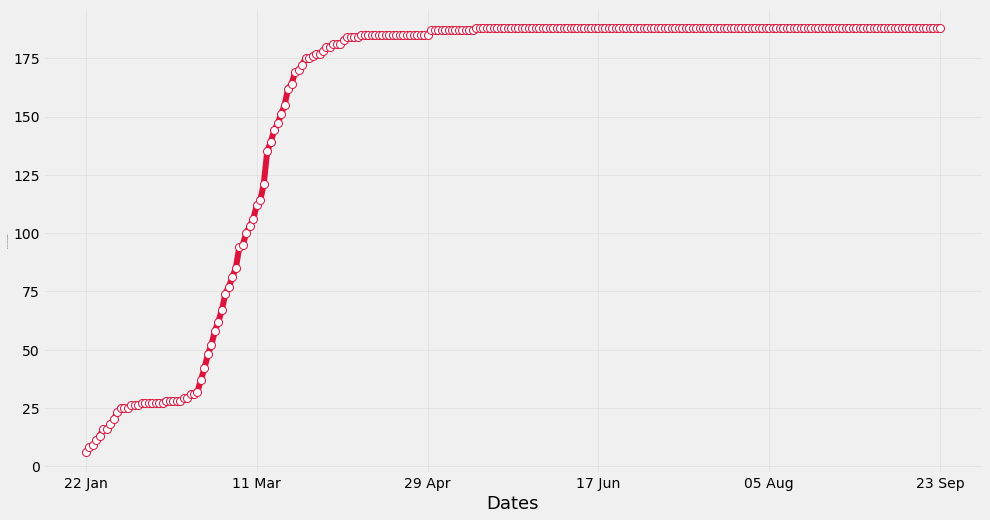

In [ ]:
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)
marker_style = dict(c="crimson",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=1)
plt.grid(alpha = 0.3)

plt.show()
plt.close()


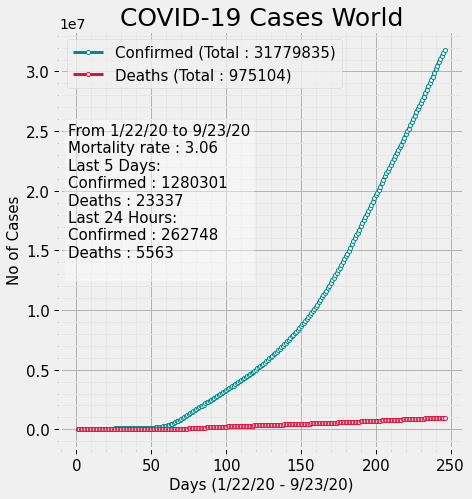

In [ ]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))
visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

plt.show()
plt.close()

## Covid's 19 progress in all continents (subplots)

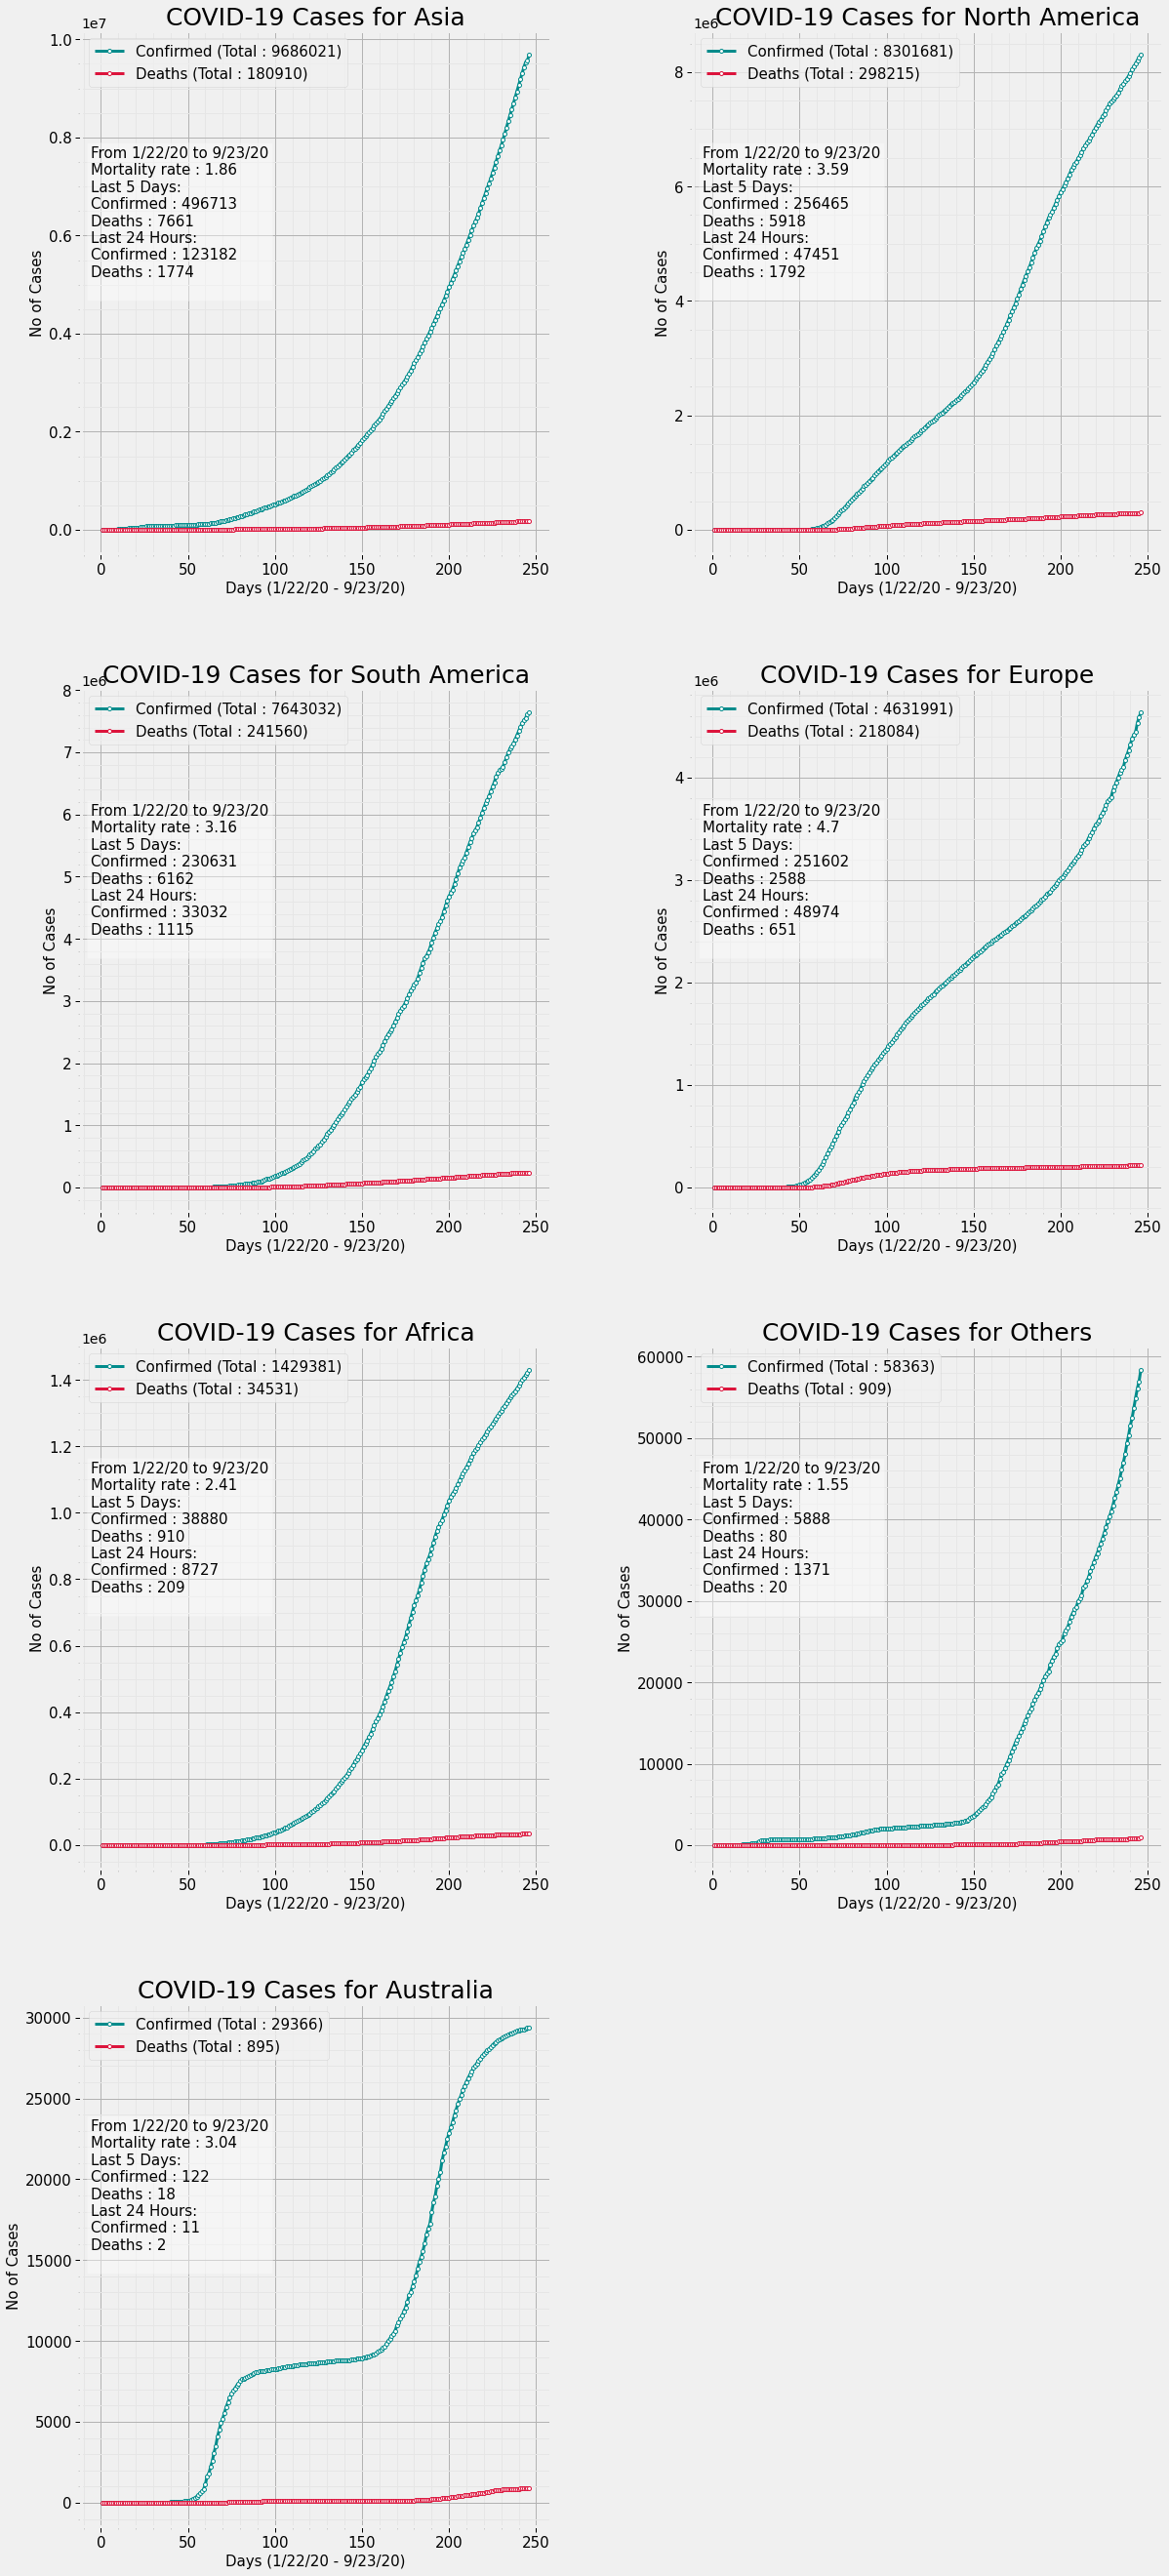

In [ ]:
df_continents= df_confirmed.groupby(["continent"]).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index

cols =2
rows = int(np.ceil(continents.shape[0]/cols))
f = plt.figure(figsize=(20,10*rows))
for i,continent in enumerate(continents):
    visualize_covid_cases(df_confirmed, df_deaths, continent = continent,figure = [f,rows,cols, i+1])

plt.show()

## Europe Maps


Create separate dataframes for Europe

In [ ]:
df_Europe = df_covid19[df_covid19["continent"]=="Europe"]
confEur = df_confirmed[df_confirmed["continent"]=="Europe"]
deathsEur = df_deaths[df_deaths["continent"]=="Europe"]

In [ ]:
Europe_map = folium.Map(location=[30,10], tiles="cartodbpositron", zoom_start=3,max_zoom=6,min_zoom=2)
for i in range(0,len(confEur)):
    folium.Circle(
        location=[confEur.iloc[i]['Lat'], confEur.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+confEur.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(confEur.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(confEur.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(deathsEur.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(deathsEur.iloc[i,-1]/(confEur.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(confEur.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(Europe_map)


## Europe Map (and colonies lol)

In [ ]:
Europe_map

## Heatmaps for Europe

In [ ]:
df_countries_cases.head()

country  Confirmed  Deaths  Recovered  Active ISO3
country                                                            
Afghanistan  Afghanistan      39994    1480      33354    5160  AFG
Albania          Albania      15752     429       9675    5648  ALB
Algeria          Algeria      53399    1818      37492   14089  DZA
Andorra          Andorra       2995      57       1928    1010  AND
Angola            Angola       6680     222       2761    3697  AGO

In [ ]:
df_Europe.index = df_Europe["country"]

## Europe's Heat Map (confirmed)

In [ ]:
temp_df = pd.DataFrame(df_Europe['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
#fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Greens")
fig.show()


## Europe's Heat Map (Deaths)

In [ ]:
temp_df = pd.DataFrame(df_Europe['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
#fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Europes' Deaths Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Deaths (Log Scale)",colorscale="Reds")
fig.show()
